In [1]:
import tensorflow as tf
tf.enable_eager_execution()
# Check eager execution is enabled
print(tf.executing_eagerly())        # => True

True


## Prepare file paths

Set `DATASET_PATH` to your dataset folder. It should have the following structure, otherwise there might be errors.
```
DATASET_PATH/
|
+- mp3/
|  +- MP3 files
|
+- wav/
|  +- For storing wav files
|
+- melspecs/
|  +- Converted mel-spectrums. Vary in length (64 x something)
|
+- zoomed/
|  +- Zoomed 64x5000 matrices. Not used as of now.
|
+- flat/
   +- Final, cropped and flattened 1x320000 vectors.
```

Only the `mp3` folder needs to have files it. Other folder can be empty, and will be populated by code below.

In [2]:
from os.path import join, split, splitext
from glob import glob

DATASET_PATH = '/home/sean/Storage/Datasets/Birp'
MP3_PATH = join(DATASET_PATH, 'mp3')
WAV_PATH = join(DATASET_PATH, 'wav')
MSPEC_PATH = join(DATASET_PATH, 'melspecs')
ZOOMED_PATH = join(DATASET_PATH, 'zoomed')
FLAT_PATH = join(DATASET_PATH, 'flat')


mp3_files = glob(join(MP3_PATH, '*.mp3'))
wav_files = glob(join(WAV_PATH, '*.wav'))
npy_files = glob(join(MSPEC_PATH, '*.npy'))
zoomed_files = glob(join(ZOOMED_PATH, '*.npy'))
flat_files = glob(join(FLAT_PATH, '*.npy'))

## Demo for mel-spectrum conversion

The code below are for demo purposes save for the `read_waveform` function.

In [3]:
def read_waveform(filepath, sampling_rate=44100):
    wav_binary = tf.read_file(filepath)

    waveform = tf.contrib.ffmpeg.decode_audio (
        wav_binary, 
        file_format='wav', 
        samples_per_second=sampling_rate, 
        channel_count=1
    )
    
    return waveform

In [4]:
# FOR DEMO PURPOSES

import matplotlib.pyplot as plt

sampling_rate = 44100

waveform = read_waveform(wav_files[0])
print(waveform.numpy().shape)

# Plot a section of the waveform.
plt.plot(waveform.numpy().flatten())
plt.show()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This will be deleted and should not be used.
(4299750, 1)


<Figure size 640x480 with 1 Axes>

In [5]:
# FOR DEMO PURPOSES

# Reshape the signals to shape of (batch_size, samples).
signals = tf.reshape(waveform, [1, -1])

# Step 1 : signals->stfts
# `stfts` is a complex64 Tensor representing the Short-time Fourier Transform of
# each signal in `signals`. Its shape is [batch_size, ?, fft_unique_bins]
# where fft_unique_bins = fft_length // 2 + 1 = 513.
stfts = tf.contrib.signal.stft(
    signals, 
    frame_length=1024, 
    frame_step=512, 
    fft_length=1024
)

In [6]:
# FOR DEMO PURPOSES

# An energy spectrogram is the magnitude of the complex-valued STFT.
# A float32 Tensor of shape [batch_size, ?, 513].
magnitude_spectrograms = tf.abs(stfts)

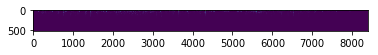

In [7]:
# FOR DEMO PURPOSES

import numpy as np
array = magnitude_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

(1, 8396, 64)


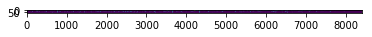

In [8]:
# FOR DEMO PURPOSES

# Warp the linear-scale, magnitude spectrograms into the mel-scale.
num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000, 64

linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
    num_mel_bins, 
    num_spectrogram_bins, 
    sampling_rate, 
    lower_edge_hertz, 
    upper_edge_hertz
)

mel_spectrograms = tf.tensordot(magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

print(mel_spectrograms.numpy().shape)

array = mel_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

(1, 8396, 64)
(8396, 64)


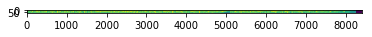

In [9]:
# FOR DEMO PURPOSES

log_offset = 1e-6
log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

print(log_mel_spectrograms.numpy().shape)
array = log_mel_spectrograms.numpy()[0]
print(array.shape)
plt.imshow(np.swapaxes(array,0,1))

## Process the files

In [ ]:
for mp3 in mp3_files:
    mp3_name = splitext(split(mp3)[1])[0]
    wav_name = mp3_name + '.wav'
    wav_file = join(wav_path, wav_name)

    if wav_file not in wav_files:
        command = ['ffmpeg', '-i', mp3_file, '-vn', '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '44100', '-f', 'wav', wav_file]
        subprocess.run(command)

In [10]:
for wav in wav_files:
    if join(MSPEC_PATH, splitext(split(wav)[1])[0][6:] + '.npy') not in npy_files:
        print('Processing', split(wav)[1], '...')
        waveform = read_waveform(wav)
        # Reshape the signals to shape of (batch_size, samples).
        signals = tf.reshape(waveform, [1, -1])

        # Step 1 : signals->stfts
        # `stfts` is a complex64 Tensor representing the Short-time Fourier Transform of
        # each signal in `signals`. Its shape is [batch_size, ?, fft_unique_bins]
        # where fft_unique_bins = fft_length // 2 + 1 = 513.
        stfts = tf.contrib.signal.stft(signals, frame_length=1024, frame_step=512, fft_length=1024)

        # An energy spectrogram is the magnitude of the complex-valued STFT.
        # A float32 Tensor of shape [batch_size, ?, 513].
        magnitude_spectrograms = tf.abs(stfts)

        # Warp the linear-scale, magnitude spectrograms into the mel-scale.
        num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

        sampling_rate, lower_edge_hertz, upper_edge_hertz, num_mel_bins = 44100, 80.0, 8000, 64

        linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
            num_mel_bins, 
            num_spectrogram_bins, 
            sampling_rate, 
            lower_edge_hertz, 
            upper_edge_hertz
        )

        mel_spectrograms = tf.tensordot(magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

        log_offset = 1e-6
        log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

        array = log_mel_spectrograms.numpy()[0]
        print(array.shape)

        np.save(join(MSPEC_PATH, splitext(split(wav)[1])[0][6:] + '.npy'), array)

In [11]:
from scipy.ndimage import zoom

target_length = 5000

for npy in npy_files:
    if join(ZOOMED_PATH, split(npy)[1]) not in zoomed_files:
        print('Processing', split(npy)[1], '...')
        array = np.load(npy)
        
        zoom_factor = (target_length / array.shape[0], 1.0)
        zoomed_array = zoom(array, zoom_factor)[0:target_length, :]
        
        print(zoomed_array.shape)
        
        np.save(join(ZOOMED_PATH, split(npy)[1]), zoomed_array)

In [12]:
for i, npy in enumerate(npy_files):
    if join(FLAT_PATH, split(npy)[1]) not in flat_files:
        print('Processing', split(npy)[1], '...')
        array = np.load(npy)[:target_length, :]
        
        flat_array = np.reshape(array, array.shape[0] * array.shape[1])
        
        print(flat_array.shape)
        
        np.save(join(FLAT_PATH, split(npy)[1]), flat_array)